# **Company Information:**

Lending Club is a peer to peer lending company based in the United States, in which investors provide funds for potential borrowers and investors earn a profit depending on the risk they take (the borrowers credit score). Lending Club provides the "bridge" between investors and borrowers.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
filepath = "/content/drive/MyDrive/Colab Notebooks/loan.csv"

In [3]:
!pip install chart-studio

In [4]:
# Import libraries we are going to use for our data analysis.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, precision_recall_curve

# Plotly visualizations (using chart-studio)
from plotly import tools
from chart_studio import plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# For oversampling Library (Dealing with Imbalanced Datasets)
from imblearn.over_sampling import SMOTE
from collections import Counter

# Other Libraries
import time

%matplotlib inline

sns.set_style('whitegrid')



In [5]:
df = pd.read_csv(filepath, low_memory=False)

# Copy of the dataframe
original_df = df.copy()

df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842554 non-null  object 
 12  home_ownership               887379 non-null  object 
 13 

In [7]:
# Replace the name of some columns
df = df.rename(columns={"loan_amnt": "loan_amount", "funded_amnt": "funded_amount", "funded_amnt_inv": "investor_funds",
                       "int_rate": "interest_rate", "annual_inc": "annual_income"})

# Drop irrelevant columns
df.drop(['id', 'member_id', 'emp_title', 'url', 'desc', 'zip_code', 'title'], axis=1, inplace=True)

# **Similar Distributions:**

We will start by exploring the distribution of the loan amounts and see when did the loan amount issued increased significantly.

What we need to know:


*   Understand what amount was mostly issued to borrowers.
*   Which year issued the most loans.
*   The distribution of loan amounts is a multinomial distribution .


# **Summary:**



*   Most of the loans issued were in the range of 10,000 to 20,000 USD.
*   The year of 2015 was the year were most loans were issued.
*   Loans were issued in an incremental manner. (Possible due to a recovery in the U.S economy)
*   The loans applied by potential borrowers, the amount issued to the borrowers and the amount funded by investors are similarly distributed, meaning that it is most likely that qualified borrowers are going to get the loan they had applied for.


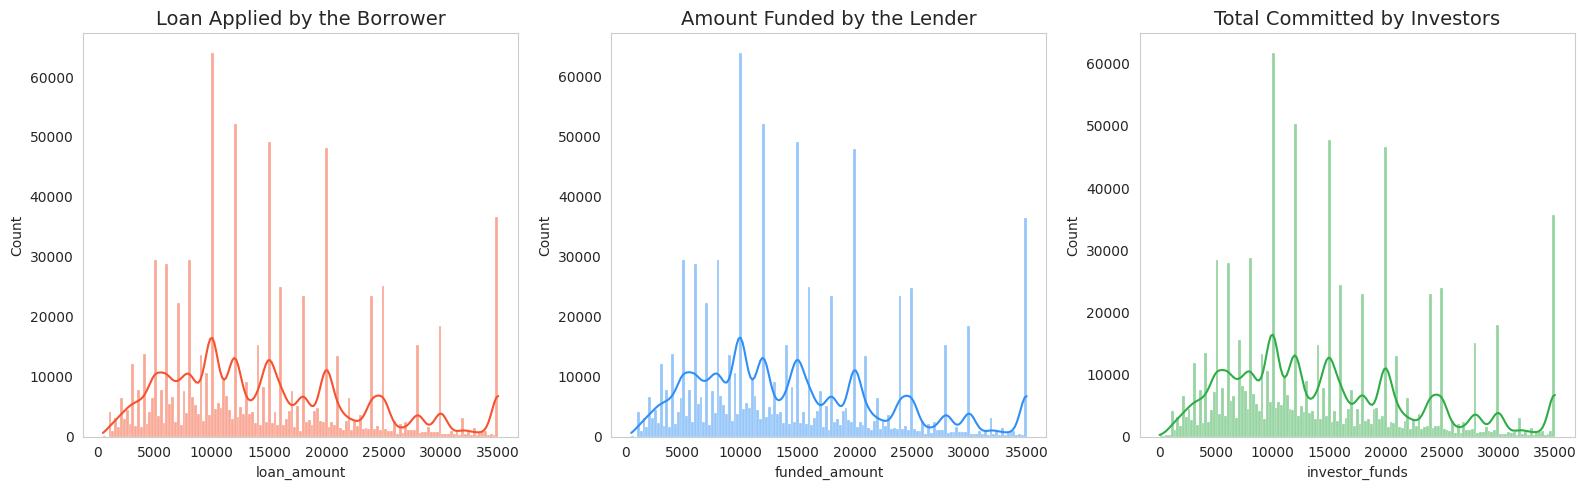

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))

# Loan applied by the borrower
sns.histplot(
    df["loan_amount"],
    ax=ax[0],
    kde=True,
    color="#F7522F"
)
ax[0].set_title("Loan Applied by the Borrower", fontsize=14)

# Amount funded by the lender
sns.histplot(
    df["funded_amount"],
    ax=ax[1],
    kde=True,
    color="#2F8FF7"
)
ax[1].set_title("Amount Funded by the Lender", fontsize=14)

# Total committed by investors
sns.histplot(
    df["investor_funds"],
    ax=ax[2],
    kde=True,
    color="#2EAD46"
)
ax[2].set_title("Total Committed by Investors", fontsize=14)

for a in ax:
    a.grid(False)

plt.tight_layout()
plt.show()


In [9]:
# strip any stray whitespace
df['issue_d_clean'] = df['issue_d'].str.strip()

# try parsing as abbreviated‐month + 2-digit year
dt1 = pd.to_datetime(df['issue_d_clean'],
                     format='%b-%y',
                     errors='coerce')

# try parsing as abbreviated‐month + 4-digit year
dt2 = pd.to_datetime(df['issue_d_clean'],
                     format='%b-%Y',
                     errors='coerce')

# combine: prefer dt1, fall back to dt2
dt = dt1.fillna(dt2)

# if you still get NaT for some rows, you can inspect them:
missing = df.loc[dt.isna(), 'issue_d_clean'].unique()
print("Unparsed patterns:", missing)

# finally extract the year
df['year'] = dt.dt.year

Unparsed patterns: []


<ipython-input-10-d223c47c7776>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




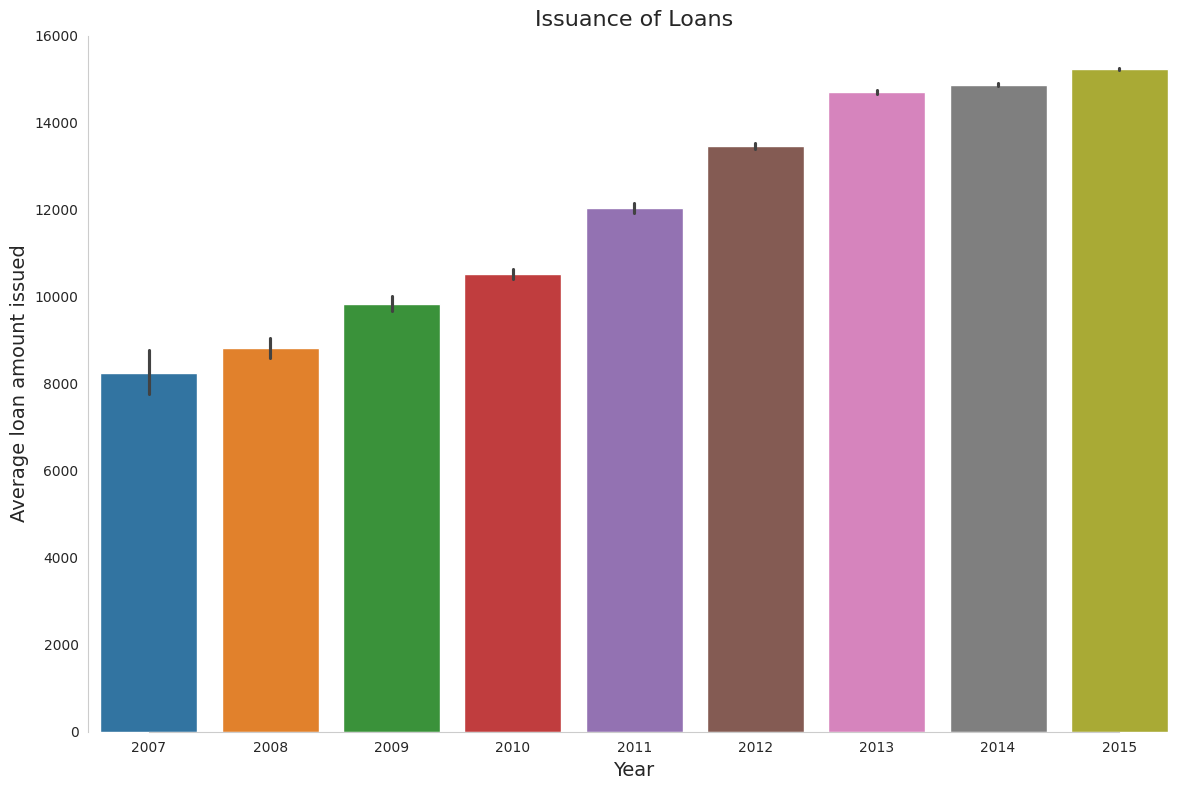

In [10]:
# The year of 2015 was the year were the highest amount of loans were issued
# This is an indication that the economy is quiet recovering itself.

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='year', y='loan_amount', data=df, palette='tab10', ax=ax)

# Turn off grid lines
ax.grid(False)

# (Optional) Tidy up spines for a cleaner look
sns.despine(fig=fig, trim=True)

plt.title('Issuance of Loans', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average loan amount issued', fontsize=14)
plt.tight_layout()
plt.show()

# **Good Loans vs Bad Loans:**

## **Types of Loans:**

In this section, we will see what is the amount of bad loans Lending Club has declared so far, of course we have to understand that there are still loans that are at a risk of defaulting in the future.

### **What we need to know:**

*   The amount of bad loans could increment as the days pass by, since we still have a great amount of current loans.

*   Average annual income is an important key metric for finding possible opportunities of investments in a specific region.

### **Summary:**


*   Currently, bad loans consist 7.60% of total loans but remember that we still have current loans which have the risk of becoming bad loans. (So this percentage is subjected to possible changes.)
*   The NorthEast region seems to be the most attractive in term of funding loans to borrowers.
*   The SouthWest and West regions have experienced a slight increase in the "median income" in the past years.
*   Average interest rates have declined since 2012 but this might explain the increase in the volume of loans.
*   Employment Length tends to be greater in the regions of the SouthWest and West.
*   Clients located in the regions of NorthEast and MidWest have not experienced a drastic increase in debt-to-income(dti) as compared to the other regions.

In [11]:
df["loan_status"].value_counts()

,count
loan_status,
Current,601779
Fully Paid,207723
Charged Off,45248
Late (31-120 days),11591
Issued,8460
In Grace Period,6253
Late (16-30 days),2357
Does not meet the credit policy. Status:Fully Paid,1988
Default,1219


In [12]:
# Determining the loans that are bad from loan_status column

bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period",
            "Late (16-30 days)", "Late (31-120 days)"]


df['loan_condition'] = np.nan

def loan_condition(status):
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'


df['loan_condition'] = df['loan_status'].apply(loan_condition)

[Text(0, 0.5, '(%)')]

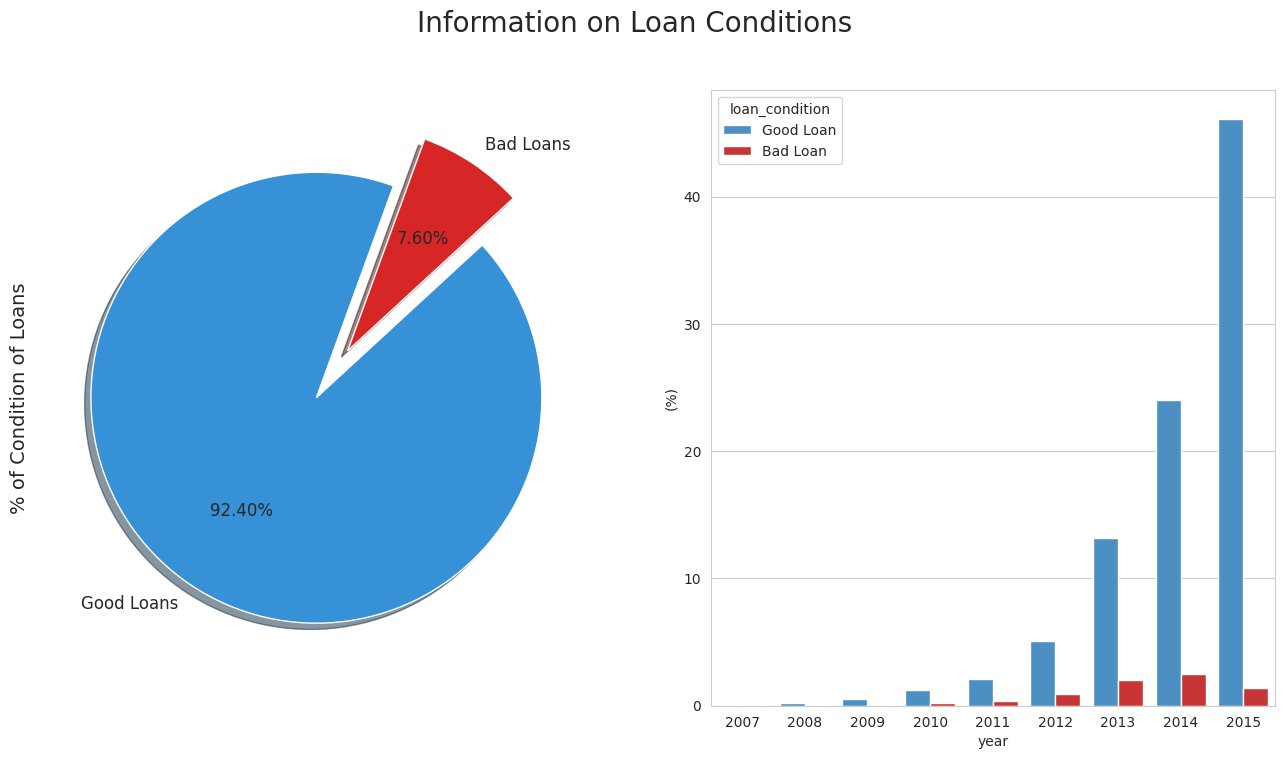

In [13]:
f, ax = plt.subplots(1,2, figsize=(16,8))

colors = ["#3791D7", "#D72626"]
labels ="Good Loans", "Bad Loans"

plt.suptitle('Information on Loan Conditions', fontsize=20)

df["loan_condition"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[0], shadow=True, colors=colors,
                                             labels=labels, fontsize=12, startangle=70)


# ax[0].set_title('State of Loan', fontsize=16)
ax[0].set_ylabel('% of Condition of Loans', fontsize=14)

# sns.countplot('loan_condition', data=df, ax=ax[1], palette=colors)
# ax[1].set_title('Condition of Loans', fontsize=20)
# ax[1].set_xticklabels(['Good', 'Bad'], rotation='horizontal')
palette = ["#3791D7", "#E01E1B"]

sns.barplot(x="year", y="loan_amount", hue="loan_condition", data=df, palette=palette, estimator=lambda x: len(x) / len(df) * 100)
ax[1].set(ylabel="(%)")

# **Loans Issued by Region**

In this section we want to analyse loans issued by region in order to see region patters that will allow us to understand which region gives Lending Club.

### **Summary:**


*   SouthEast , West and NorthEast regions had the highest amount lof loans issued.
*   West and SouthWest had a rapid increase in debt-to-income starting in 2012.
*   West and SouthWest had a rapid decrease in interest rates (This might explain the increase in debt to income).

In [14]:
df['addr_state'].unique()

# Make a list with each of the regions by state.

west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']



df['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'



df['region'] = df['addr_state'].apply(finding_regions)

In [15]:
# This code will take the current date and transform it into a year-month format
df['issue_period'] = (
    pd.to_datetime(df['issue_d'].str.strip(),
                   format='%b-%Y',    # e.g. "Dec-2011"
                   errors='coerce')   # (should be none, but just in case)
      .dt.to_period('M')
)

In [16]:
good = df.dropna(subset=['issue_period'])

# Sum loan_amount (in thousands) per month & region
df_dates = (
    good
    .groupby(['issue_period','region'], as_index=False)['loan_amount']
    .sum()
)
df_dates['loan_amount'] /= 1_000

# Rename for clarity (and plotting)
df_dates.rename(columns={'issue_period':'year_month'}, inplace=True)

print(df_dates.head())

  year_month     region  loan_amount
0    2007-06    MidWest         6.90
1    2007-06  NorthEast        67.70
2    2007-06  SouthEast        13.45
3    2007-06  SouthWest         1.20
4    2007-06       West         2.60


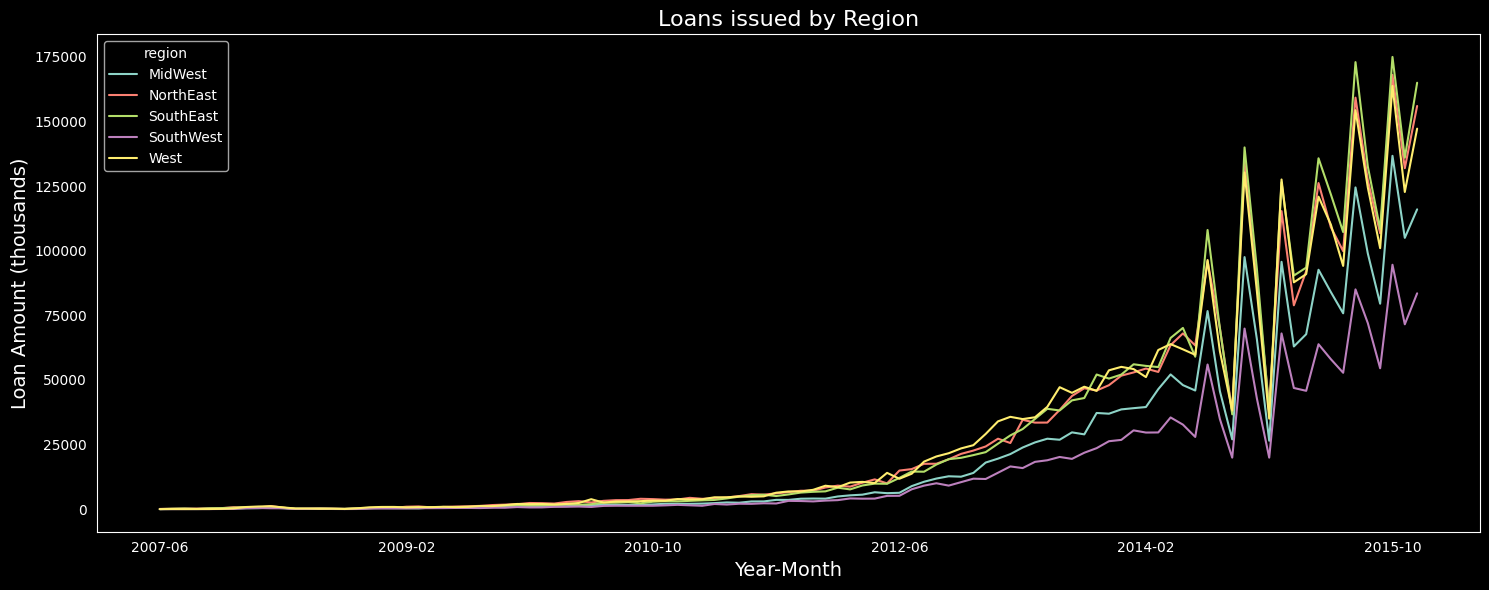

In [17]:
pivot = df_dates.pivot_table(
    index='year_month',
    columns='region',
    values='loan_amount',
    aggfunc='sum'
).fillna(0)

# convert PeriodIndex to string for nice ticks
pivot.index = pivot.index.astype(str)

plt.style.use('dark_background')
ax = pivot.plot(
    figsize=(15,6),
    colormap=plt.cm.Set3,
    grid=False       # ⟵ turns grid off
)
ax.set_title('Loans issued by Region', fontsize=16)
ax.set_xlabel('Year-Month', fontsize=14)
ax.set_ylabel('Loan Amount (thousands)', fontsize=14)
plt.tight_layout()
plt.show()

In [18]:
employment_length = ['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
                    '4 years', '5 years', '6 years', '2 years', '7 years', 'n/a']

# Create a new column and convert emp_length to integers.

lst = [df]
df['emp_length_int'] = np.nan

for col in lst:
    col.loc[col['emp_length'] == '10+ years', "emp_length_int"] = 10
    col.loc[col['emp_length'] == '9 years', "emp_length_int"] = 9
    col.loc[col['emp_length'] == '8 years', "emp_length_int"] = 8
    col.loc[col['emp_length'] == '7 years', "emp_length_int"] = 7
    col.loc[col['emp_length'] == '6 years', "emp_length_int"] = 6
    col.loc[col['emp_length'] == '5 years', "emp_length_int"] = 5
    col.loc[col['emp_length'] == '4 years', "emp_length_int"] = 4
    col.loc[col['emp_length'] == '3 years', "emp_length_int"] = 3
    col.loc[col['emp_length'] == '2 years', "emp_length_int"] = 2
    col.loc[col['emp_length'] == '1 year', "emp_length_int"] = 1
    col.loc[col['emp_length'] == '< 1 year', "emp_length_int"] = 0.5
    col.loc[col['emp_length'] == 'n/a', "emp_length_int"] = 0

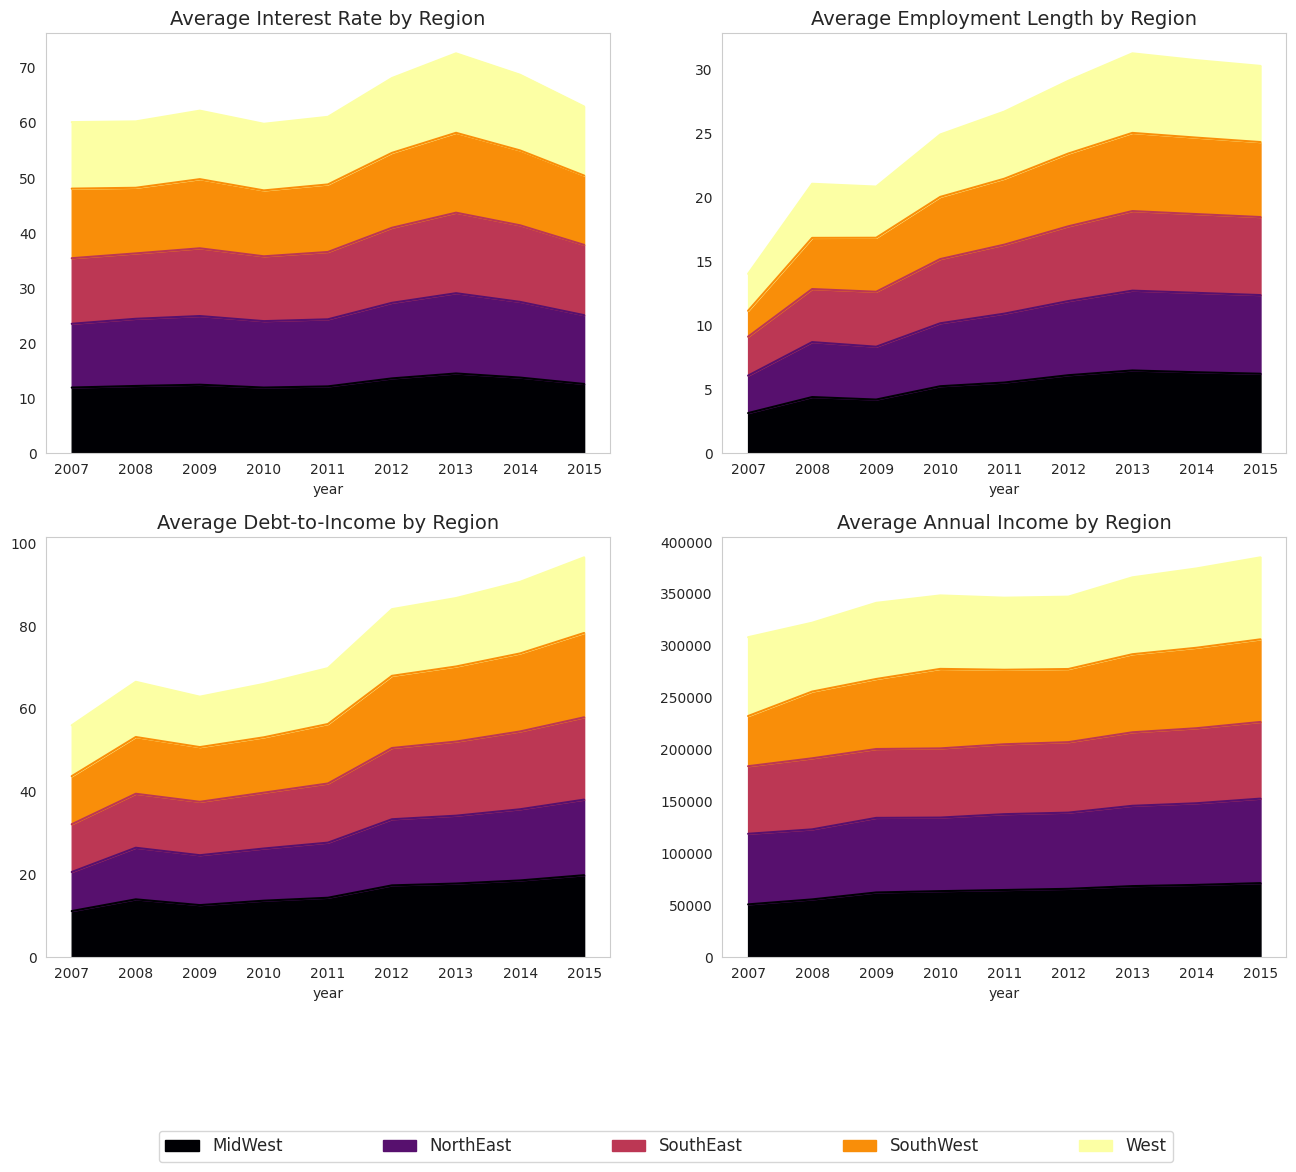

In [19]:
# Loan issued by Region and by Credit Score grade
# Change the colormap for tomorrow!

sns.set_style('whitegrid')

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
cmap = plt.cm.inferno

by_interest_rate = df.groupby(['year', 'region']).interest_rate.mean()
by_interest_rate.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, legend=False, ax=ax1, figsize=(16,12))
ax1.set_title('Average Interest Rate by Region', fontsize=14)


by_employment_length = df.groupby(['year', 'region']).emp_length_int.mean()
by_employment_length.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, legend=False, ax=ax2, figsize=(16,12))
ax2.set_title('Average Employment Length by Region', fontsize=14)
# plt.xlabel('Year of Issuance', fontsize=14)

by_dti = df.groupby(['year', 'region']).dti.mean()
by_dti.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, legend=False, ax=ax3, figsize=(16,12))
ax3.set_title('Average Debt-to-Income by Region', fontsize=14)

by_income = df.groupby(['year', 'region']).annual_income.mean()
by_income.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, ax=ax4, figsize=(16,12))
ax4.set_title('Average Annual Income by Region', fontsize=14)
ax4.legend(bbox_to_anchor=(-1.0, -0.5, 1.8, 0.1), loc=10,prop={'size':12},
           ncol=5, mode="expand", borderaxespad=0.)

# **A Deeper Look into Bad Loans:**

## **What we need to know:**


*   The number of loans that were classified as bad loans for each region by its loan status. (This will be shown in a dataframe below.)
*   This won't give us the exact reasons why a loan is categorized as a bad loan (other variables that might have influence the condition of the loan) but it will give us a deeper insight on the level of risk in a particular region.

## **Summary:**



*   The regions of the West and SouthEast had a higher percentage in most of the b "bad" loan statuses.
*   The NorthEast region had a higher percentage in Grace Period and Does not meet Credit Policy loan status. However, both of these are not considered as bad as default for instance.
*   Based on this small and brief summary we can conclude that the West and SouthEast regions have the most undesirable loan status, but just by a slightly higher percentage compared to the NorthEast region.
*   Again, this does not tell us what causes a loan to be a bad loan , but it gives us some idea about the level of risk within the regions across the United States.

In [20]:
# We have 67429 loans categorized as bad loans
badloans_df = df.loc[df["loan_condition"] == "Bad Loan"]

# loan_status cross
loan_status_cross = pd.crosstab(badloans_df['region'], badloans_df['loan_status']).apply(lambda x: x/x.sum() * 100)
number_of_loanstatus = pd.crosstab(badloans_df['region'], badloans_df['loan_status'])


# Round our values
loan_status_cross['Charged Off'] = loan_status_cross['Charged Off'].apply(lambda x: round(x, 2))
loan_status_cross['Default'] = loan_status_cross['Default'].apply(lambda x: round(x, 2))
loan_status_cross['Does not meet the credit policy. Status:Charged Off'] = loan_status_cross['Does not meet the credit policy. Status:Charged Off'].apply(lambda x: round(x, 2))
loan_status_cross['In Grace Period'] = loan_status_cross['In Grace Period'].apply(lambda x: round(x, 2))
loan_status_cross['Late (16-30 days)'] = loan_status_cross['Late (16-30 days)'].apply(lambda x: round(x, 2))
loan_status_cross['Late (31-120 days)'] = loan_status_cross['Late (31-120 days)'].apply(lambda x: round(x, 2))


number_of_loanstatus['Total'] = number_of_loanstatus.sum(axis=1)
# number_of_badloans
number_of_loanstatus

loan_status,Charged Off,Default,Does not meet the credit policy. Status:Charged Off,In Grace Period,Late (16-30 days),Late (31-120 days),Total
region,,,,,,,
MidWest,7361,175,142,926,354,1820,10778
NorthEast,10671,263,190,1625,585,2799,16133
SouthEast,11094,297,184,1579,600,2925,16679
SouthWest,4774,166,79,708,273,1407,7407
West,11348,318,166,1415,545,2640,16432


In [21]:
import plotly.io as pio

# make sure we're using the Colab renderer
pio.renderers.default = "colab"

charged_off = loan_status_cross['Charged Off'].values.tolist()
default = loan_status_cross['Default'].values.tolist()
not_meet_credit = loan_status_cross['Does not meet the credit policy. Status:Charged Off'].values.tolist()
grace_period = loan_status_cross['In Grace Period'].values.tolist()
short_pay = loan_status_cross['Late (16-30 days)'] .values.tolist()
long_pay = loan_status_cross['Late (31-120 days)'].values.tolist()



charged = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= charged_off,
    name='Charged Off',
    marker=dict(
        color='rgb(192, 148, 246)'
    ),
    text = '%'
)

defaults = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y=default,
    name='Defaults',
    marker=dict(
        color='rgb(176, 26, 26)'
    ),
    text = '%'
)

credit_policy = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= not_meet_credit,
    name='Does not meet Credit Policy',
    marker = dict(
        color='rgb(229, 121, 36)'
    ),
    text = '%'
)

grace = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= grace_period,
    name='Grace Period',
    marker = dict(
        color='rgb(147, 147, 147)'
    ),
    text = '%'
)

short_pays = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= short_pay,
    name='Late Payment (16-30 days)',
    marker = dict(
        color='rgb(246, 157, 135)'
    ),
    text = '%'
)

long_pays = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= long_pay,
    name='Late Payment (31-120 days)',
    marker = dict(
        color = 'rgb(238, 76, 73)'
        ),
    text = '%'
)




data = [charged, defaults, credit_policy, grace, short_pays, long_pays]
layout = go.Layout(
    barmode='stack',
    title = '% of Bad Loan Status by Region',
    xaxis=dict(title='US Regions')
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stacked-bar')


In [22]:
# Average interest rates clients pay
df['interest_rate'].mean()
# Average annual income of clients
df['annual_income'].mean()

np.float64(75027.5877607663)

# **The Business Perspective**

## **Understanding the Operative Side of Business**

Now we will have a closer look at the operative side of business by state. This will give us a clearer idea in which state we have a higher operating activity. This will allow us to ask further questions such as Why do we have a higher level of operating activity in this state? Could it be because of economic factors? or the risk level is low and returns are fairly decent? Let's explore!

## **What we need to know:**


*   We will focus on three key metrics: Loans issued by state (Total Sum), Average interest rates charged to customers and average annual income of all customers by state.
*   The purpose of this analysis is to see states that give high returns at a descent risk.



## **Summary:**



*   California, Texas, New York and Florida are the states in which the highest amount of loans were issued.
*   Interesting enough, all four states have a approximate interest rate of 13% which is at the same level of the average interest rate for all states (13.24%)
*   California, Texas and New York are all above the average annual income (with the exclusion of Florida), this might give possible indication why most loans are issued in these states.


In [23]:
# Plotting by states

# Grouping by our metrics
# First Plotly Graph (We evaluate the operative side of the business)
by_loan_amount = df.groupby(['region','addr_state'], as_index=False).loan_amount.sum()
by_interest_rate = df.groupby(['region', 'addr_state'], as_index=False).interest_rate.mean()
by_income = df.groupby(['region', 'addr_state'], as_index=False).annual_income.mean()



# Take the values to a list for visualization purposes.
states = by_loan_amount['addr_state'].values.tolist()
average_loan_amounts = by_loan_amount['loan_amount'].values.tolist()
average_interest_rates = by_interest_rate['interest_rate'].values.tolist()
average_annual_income = by_income['annual_income'].values.tolist()


from collections import OrderedDict

# Figure Number 1 (Perspective for the Business Operations)
metrics_data = OrderedDict([('state_codes', states),
                            ('issued_loans', average_loan_amounts),
                            ('interest_rate', average_interest_rates),
                            ('annual_income', average_annual_income)])


metrics_df = pd.DataFrame.from_dict(metrics_data)
metrics_df = metrics_df.round(decimals=2)
metrics_df.head()


,state_codes,issued_loans,interest_rate,annual_income
0,IA,114075.0,12.63,44756.21
1,IL,539068450.0,13.10,76898.22
2,IN,202493900.0,13.46,67989.31
3,KS,116395875.0,13.28,68841.31
4,MI,326467800.0,13.30,69378.67


In [24]:
# Now it comes the part where we plot out plotly United States map
import plotly.graph_objs as go


for col in metrics_df.columns:
    metrics_df[col] = metrics_df[col].astype(str)

scl = [[0.0, 'rgb(210, 241, 198)'],[0.2, 'rgb(188, 236, 169)'],[0.4, 'rgb(171, 235, 145)'],\
            [0.6, 'rgb(140, 227, 105)'],[0.8, 'rgb(105, 201, 67)'],[1.0, 'rgb(59, 159, 19)']]

metrics_df['text'] = metrics_df['state_codes'] + '<br>' +\
'Average loan interest rate: ' + metrics_df['interest_rate'] + '<br>'+\
'Average annual income: ' + metrics_df['annual_income']


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = metrics_df['state_codes'],
        z = metrics_df['issued_loans'],
        locationmode = 'USA-states',
        text = metrics_df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "$s USD")
        ) ]


layout = dict(
    title = 'Lending Clubs Issued Loans <br> (A Perspective for the Business Operations)',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

# **Analysis by Income Category:**

In this section we will create different income categories in order to detect important patters and go more into depth in our analysis.

## **What we need to know:**

*   Low income category: Borrowers that have an annual income lower or equal to 100,000 usd.
*   Medium income category: Borrowers that have an annual income higher than 100,000 usd but lower or equal to 200,000 usd.
*   High income category: Borrowers that have an annual income higher tha 200,000 usd.


## **Summary:**

*   Borrowers that made part of the high income category took higher loan amounts than people from low and medium income categories. Of course, people with higher annual incomes are more likely to pay loans with a higher amount. (First row to the left of the subplots)
*   Loans that were borrowed by the Low income category had a slightly higher change of becoming a bad loan. (First row to the right of the subplots)
*   Borrowers with High and Medium annual incomes had a longer employment length than people with lower incomes.(Second row to the left of the subplots)
*   Borrowers with a lower income had on average higher interest rates while people with a higher annual income had lower interest rates on their loans. (Second row to the right of the subplots)

In [25]:
# Let's create categories for annual_income since most of the bad loans are located below 100k

df['income_category'] = ""         # empty string defaults the dtype to object

for col in [df]:
    col.loc[col['annual_income'] <= 100_000, 'income_category'] = 'Low'
    col.loc[(col['annual_income'] > 100_000) & (col['annual_income'] <= 200_000), 'income_category'] = 'Medium'
    col.loc[col['annual_income'] > 200_000, 'income_category'] = 'High'

# define your bins and labels
bins = [-np.inf, 100_000, 200_000, np.inf]
labels = ['Low', 'Medium', 'High']

# this creates a Categorical column directly
df['income_category'] = pd.cut(df['annual_income'], bins=bins, labels=labels)


In [26]:
# Let's transform the column loan_condition into integrers.

lst = [df]
df['loan_condition_int'] = np.nan

for col in lst:
    col.loc[df['loan_condition'] == 'Good Loan', 'loan_condition_int'] = 0 # Negative (Bad Loan)
    col.loc[df['loan_condition'] == 'Bad Loan', 'loan_condition_int'] = 1 # Positive (Good Loan)

# Convert from float to int the column (This is our label)
df['loan_condition_int'] = df['loan_condition_int'].astype(int)

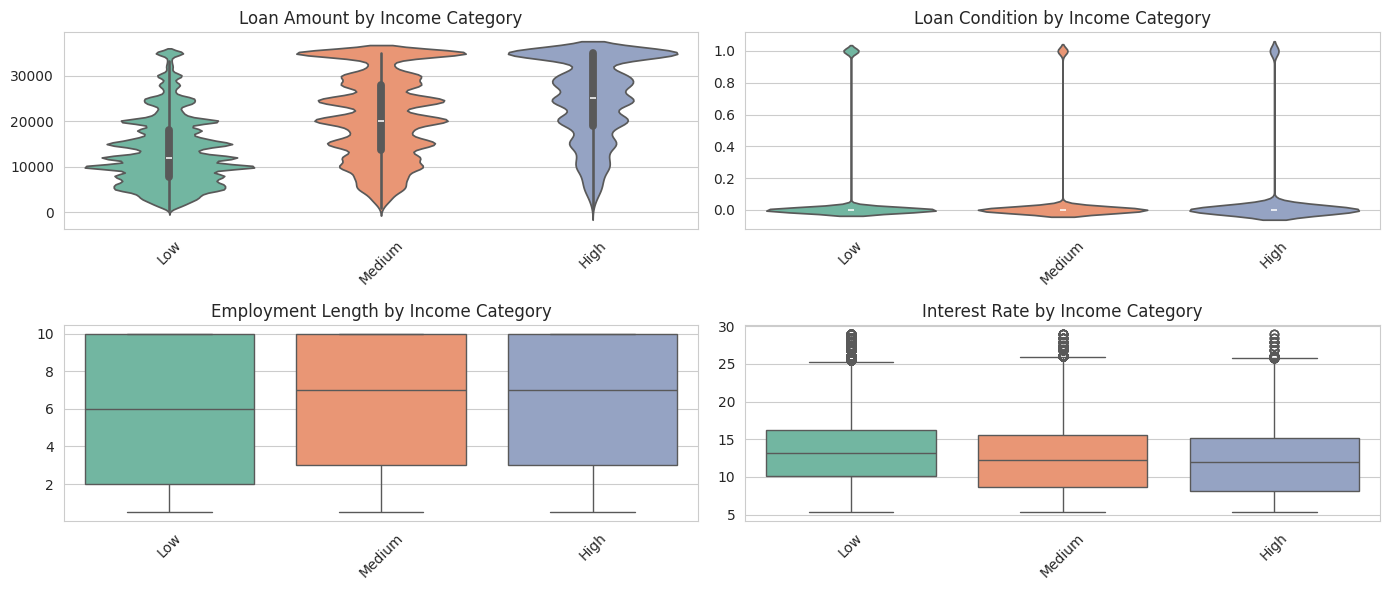

In [27]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(14,6))

# Violin of loan_amount by income_category
sns.violinplot(
    x="income_category",
    y="loan_amount",
    hue="income_category",
    data=df,
    palette="Set2",
    legend=False,
    ax=ax1
)
ax1.set_title("Loan Amount by Income Category")

# Violin of loan_condition_int by income_category
sns.violinplot(
    x="income_category",
    y="loan_condition_int",
    hue="income_category",
    data=df,
    palette="Set2",
    legend=False,
    ax=ax2
)
ax2.set_title("Loan Condition by Income Category")

# Boxplot of emp_length_int by income_category
sns.boxplot(
    x="income_category",
    y="emp_length_int",
    hue="income_category",
    data=df,
    palette="Set2",
    legend=False,
    ax=ax3
)
ax3.set_title("Employment Length by Income Category")

# Boxplot of interest_rate by income_category
sns.boxplot(
    x="income_category",
    y="interest_rate",
    hue="income_category",
    data=df,
    palette="Set2",
    legend=False,
    ax=ax4
)
ax4.set_title("Interest Rate by Income Category")

# clean up
for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlabel("")      # to remove repeated x-label
    ax.set_ylabel("")      # likewise for y-labels
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# **Assessing Risks**


## **Understanding the Risky side of Business**

Although the operative side of business is important, we have to also analyze the level of risk in each state. Credit scores are important metrics to analyze the level of risk of an individual customer. However, there are also other important metrics to somehow estimate the level of risk of other states.


## **What we need to know:**


*   Debt-to-income is an important metric since it says approximately the level of debt of each individual consumer with respect to its total income.
*   The average length of employment tells us a better story about the labor market in each state which is helpful to assess the levelof risk.


## **Summary:**


*   IOWA has the highest level of default ratio neverthless, the amount of loans issued in that state is too low. (Number of Bad loans is equal to 3)
*   California and Texas seem to have the lowest risk and the highest possible return for investors. However, I will look more deeply into these states and create other metrics analyse the level of risk for each state.



In [28]:
by_condition = df.groupby('addr_state')['loan_condition'].value_counts()/ df.groupby('addr_state')['loan_condition'].count()
by_emp_length = df.groupby(['region', 'addr_state'], as_index=False).emp_length_int.mean().sort_values(by="addr_state")

loan_condition_bystate = pd.crosstab(df['addr_state'], df['loan_condition'] )

cross_condition = pd.crosstab(df["addr_state"], df["loan_condition"])
# Percentage of condition of loan
percentage_loan_contributor = pd.crosstab(df['addr_state'], df['loan_condition']).apply(lambda x: x/x.sum() * 100)
condition_ratio = cross_condition["Bad Loan"]/cross_condition["Good Loan"]
by_dti = df.groupby(['region', 'addr_state'], as_index=False).dti.mean()
state_codes = sorted(states)


# Take to a list
default_ratio = condition_ratio.values.tolist()
average_dti = by_dti['dti'].values.tolist()
average_emp_length = by_emp_length["emp_length_int"].values.tolist()
number_of_badloans = loan_condition_bystate['Bad Loan'].values.tolist()
percentage_ofall_badloans = percentage_loan_contributor['Bad Loan'].values.tolist()


# Figure Number 2
risk_data = OrderedDict([('state_codes', state_codes),
                         ('default_ratio', default_ratio),
                         ('badloans_amount', number_of_badloans),
                         ('percentage_of_badloans', percentage_ofall_badloans),
                         ('average_dti', average_dti),
                         ('average_emp_length', average_emp_length)])


# Figure 2 Dataframe
risk_df = pd.DataFrame.from_dict(risk_data)
risk_df = risk_df.round(decimals=3)
risk_df.head()

,state_codes,default_ratio,badloans_amount,percentage_of_badloans,average_dti,average_emp_length
0,AK,0.074,151,0.224,13.656,6.256
1,AL,0.097,993,1.473,17.821,6.607
2,AR,0.083,507,0.752,19.681,6.404
3,AZ,0.084,1581,2.345,19.284,5.793
4,CA,0.088,10518,15.599,18.683,5.967


In [29]:
for col in risk_df.columns:
    risk_df[col] = risk_df[col].astype(str)

scl = [[0.0, 'rgb(202, 202, 202)'],[0.2, 'rgb(253, 205, 200)'],[0.4, 'rgb(252, 169, 161)'],\
            [0.6, 'rgb(247, 121, 108  )'],[0.8, 'rgb(232, 70, 54)'],[1.0, 'rgb(212, 31, 13)']]

risk_df['text'] = risk_df['state_codes'] + '<br>' +\
'Number of Bad Loans: ' + risk_df['badloans_amount'] + '<br>' + \
'Percentage of all Bad Loans: ' + risk_df['percentage_of_badloans'] + '%' +  '<br>' + \
'Average Debt-to-Income Ratio: ' + risk_df['average_dti'] + '<br>'+\
'Average Length of Employment: ' + risk_df['average_emp_length']


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = risk_df['state_codes'],
        z = risk_df['default_ratio'],
        locationmode = 'USA-states',
        text = risk_df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "%")
        ) ]


layout = dict(
    title = 'Lending Clubs Default Rates <br> (Analysing Risks)',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

# **The Importance of Credit Scores:**

Credit scores are important metrics for assesing the overall level of risk. In this section we will analyze the level of risk as a whole and how many loans were bad loans by the type of grade received in the credit score of the customer.

## **What we need to know:**


*   The lower the grade of the credit score, the higher the risk for investors.
*   There are different factors that influence on the level of risk of the loan.


## **Summary:**


*   The scores that has a lower grade received a larger amounts of loans (which might had contributed to a higher level of risk).
*   Logically, the lower the grade the higher the interest the customer had to pay back to investors.
*   Interstingly, customers with a grade of "C" were more likely to default on the loan


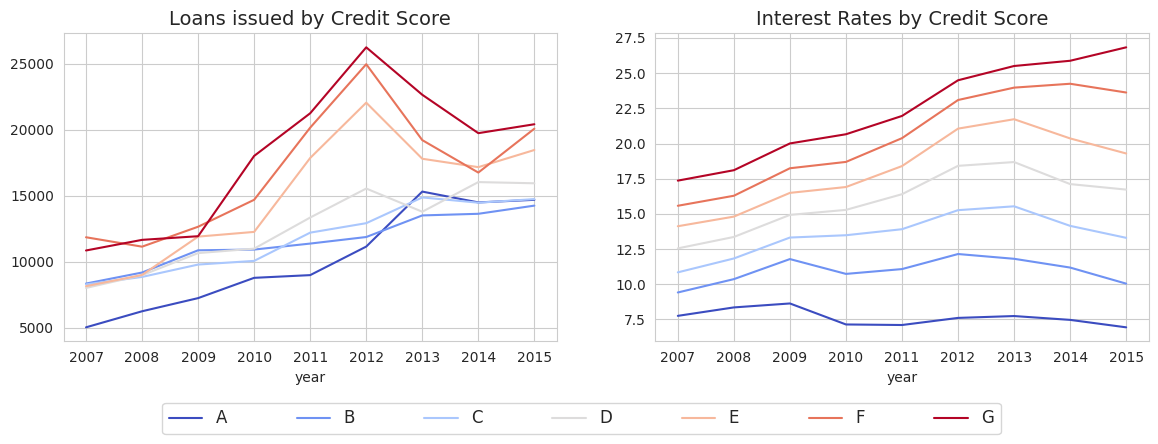

In [30]:
# Let's visualise how many loans were issued by creditscore
f, ((ax1, ax2)) = plt.subplots(1, 2)
cmap = plt.cm.coolwarm

by_credit_score = df.groupby(['year', 'grade']).loan_amount.mean()
by_credit_score.unstack().plot(legend=False, ax=ax1, figsize=(14, 4), colormap=cmap)
ax1.set_title('Loans issued by Credit Score', fontsize=14)


by_inc = df.groupby(['year', 'grade']).interest_rate.mean()
by_inc.unstack().plot(ax=ax2, figsize=(14, 4), colormap=cmap)
ax2.set_title('Interest Rates by Credit Score', fontsize=14)

ax2.legend(bbox_to_anchor=(-1.0, -0.3, 1.7, 0.1), loc=5, prop={'size':12},
           ncol=7, mode="expand", borderaxespad=0.)

Text(0, 0.5, 'Interest Rate (%)')

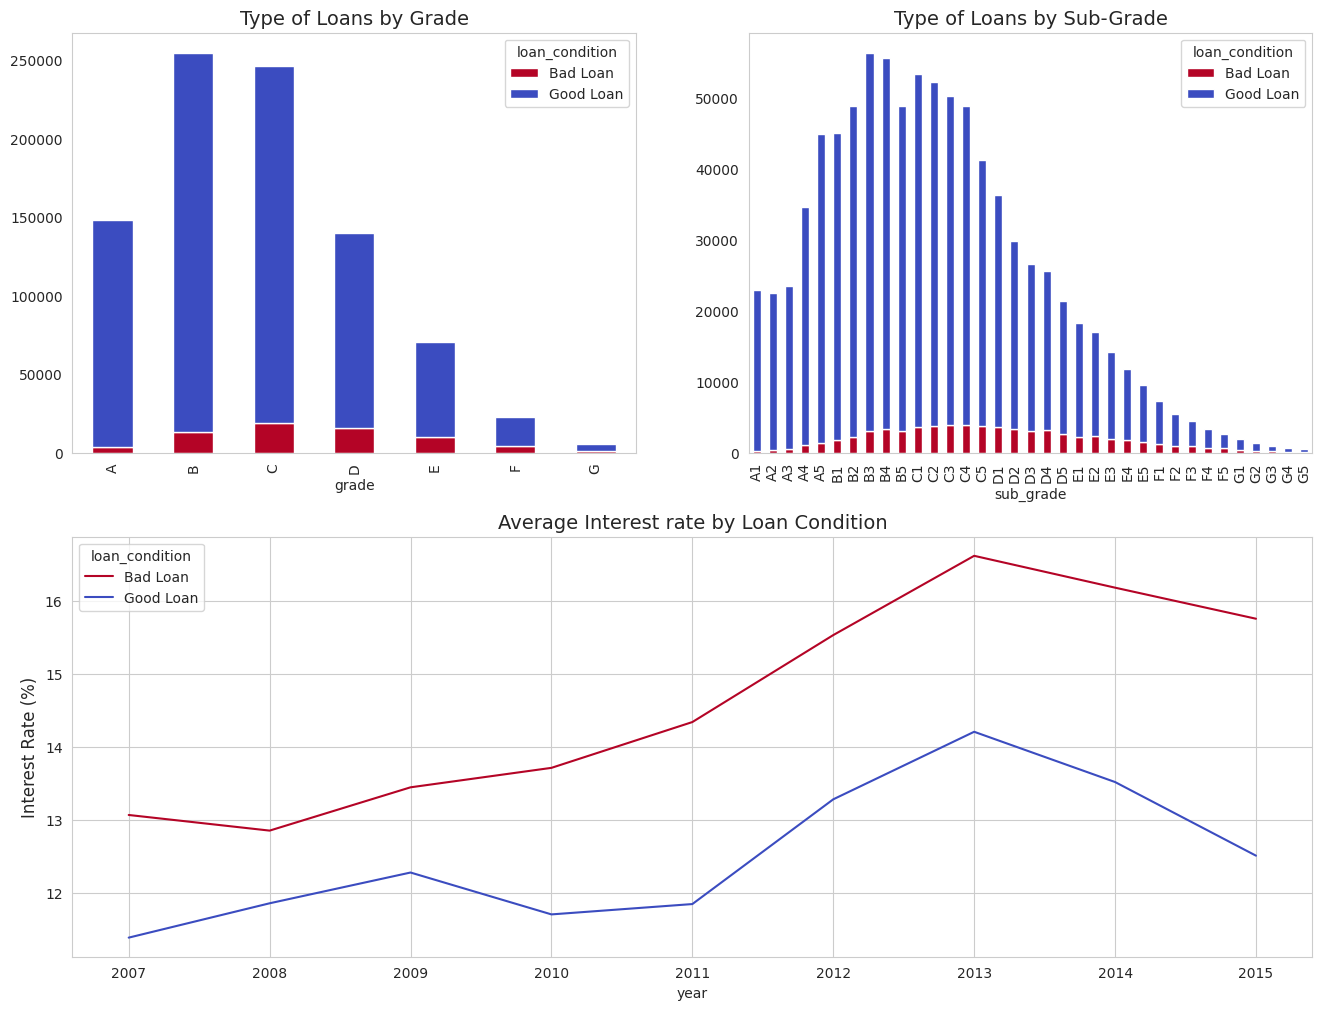

In [31]:
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

cmap = plt.cm.coolwarm_r

loans_by_region = df.groupby(['grade', 'loan_condition']).size()
loans_by_region.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax1, grid=False)
ax1.set_title('Type of Loans by Grade', fontsize=14)


loans_by_grade = df.groupby(['sub_grade', 'loan_condition']).size()
loans_by_grade.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax2, grid=False)
ax2.set_title('Type of Loans by Sub-Grade', fontsize=14)

by_interest = df.groupby(['year', 'loan_condition']).interest_rate.mean()
by_interest.unstack().plot(ax=ax3, colormap=cmap)
ax3.set_title('Average Interest rate by Loan Condition', fontsize=14)
ax3.set_ylabel('Interest Rate (%)', fontsize=12)

# **What Determines a Bad Loan**

My main aim in this section is to find the main factors that causes for a loan to be considered a "Bad Loan". Logically, we could assume that factors such as a low credit grade or a high debt to income could be possible contributors in determining whether a loan is at a high risk of being defaulted.

## **What we need to know:**


*   There might be possible factors that contribute in whether a loan is bad or not.
*   Factors that increase risk include: low annual income, high debt to income, high interest rates, low grade, among others.


## **Summary:**


*   The types of bad loans in the last year are having a tendency to decline, except for late payments (might indicate an economical recovery.)
*   Mortgage was the variable from the home ownership column that used the highest amount borrowed within loans that were considered to be bad.
*   There is a slight increase on people who have mortgages that are applying for a loan.
*   People who have a mortgage (depending on other factors as well within the mortgage) are more likely to ask for a loan.



In [32]:
# Just get the numeric variables
numeric_df = df.select_dtypes(include=[np.number])


df_correlations = numeric_df.corr()

In [33]:
print(df['interest_rate'].dtype)

float64


In [34]:
import plotly.express as px

# Select only numeric columns and build the correlation matrix
numeric_df = df.select_dtypes(include=[np.number])
df_correlations = numeric_df.corr()

# Render Plotly inline in Colab
pio.renderers.default = "colab"

# Plot with px.imshow for a quick heatmap

custom_scale = [
    [0.0,   'rgb(165,0,38)'],
    [0.111, 'rgb(215,48,39)'],
    [0.222, 'rgb(244,109,67)'],
    [0.333, 'rgb(253,174,97)'],
    [0.444, 'rgb(254,224,144)'],
    [0.556, 'rgb(224,243,248)'],
    [0.667, 'rgb(171,217,233)'],
    [0.778, 'rgb(116,173,209)'],
    [0.889, 'rgb(69,117,180)'],
    [1.0,   'rgb(49,54,149)']
]

# build the trace
trace = go.Heatmap(
    z=df_correlations.values,
    x=df_correlations.columns,
    y=df_correlations.index,
    colorscale=custom_scale,
    zmin=-1,    # force the scale from -1 to 1
    zmax= 1,
    colorbar=dict(
        title='Level of Correlation',
        titleside='top',
        tickmode='array',
        tickvals=[-1, 0, 1],
        ticktext=['−1','0','+1'],
        ticks='outside'
    )
)

# assemble and show
fig = go.Figure(data=[trace])
fig.update_layout(title='Feature Correlation Heatmap', width=800, height=800)
fig.show()


This data looks a little but messy maybe if we focus our correlation heatmap into columns that are more worth it we might actually see a trend with the condition of the loan.

In [35]:
title = 'Bad Loans: Loan Statuses'

labels = bad_loan # All the elements that comprise a bad loan.

len(labels)
colors = ['rgba(236, 112, 99, 1)', 'rgba(235, 152, 78, 1)', 'rgba(52, 73, 94, 1)', 'rgba(128, 139, 150, 1)',
         'rgba(255, 87, 51, 1)', 'rgba(255, 195, 0, 1)']

mode_size = [8,8,8,8,8,8]

line_size = [2,2,2,2,2,2]

x_data = [
    sorted(df['year'].unique().tolist()),
    sorted(df['year'].unique().tolist()),
    sorted(df['year'].unique().tolist()),
    sorted(df['year'].unique().tolist()),
    sorted(df['year'].unique().tolist()),
    sorted(df['year'].unique().tolist()),
]

# type of loans
charged_off = df['loan_amount'].loc[df['loan_status'] == 'Charged Off'].values.tolist()
defaults = df['loan_amount'].loc[df['loan_status'] == 'Default'].values.tolist()
not_credit_policy = df['loan_amount'].loc[df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off'].values.tolist()
grace_period = df['loan_amount'].loc[df['loan_status'] == 'In Grace Period'].values.tolist()
short_late = df['loan_amount'].loc[df['loan_status'] == 'Late (16-30 days)'].values.tolist()
long_late = df['loan_amount'].loc[df['loan_status'] == 'Late (31-120 days)'].values.tolist()

y_data = [
    charged_off,
    defaults,
    not_credit_policy,
    grace_period,
    short_late,
    long_late,
]

p_charged_off = go.Scatter(
    x = x_data[0],
    y = y_data[0],
    name = 'A. Charged Off',
    line = dict(
        color = colors[0],
        width = 3,
        dash='dash')
)

p_defaults = go.Scatter(
    x = x_data[1],
    y = y_data[1],
    name = 'A. Defaults',
    line = dict(
        color = colors[1],
        width = 3,
        dash='dash')
)

p_credit_policy = go.Scatter(
    x = x_data[2],
    y = y_data[2],
    name = 'Not Meet C.P',
    line = dict(
        color = colors[2],
        width = 3,
        dash='dash')
)

p_graced = go.Scatter(
    x = x_data[3],
    y = y_data[3],
    name = 'A. Graced Period',
    line = dict(
        color = colors[3],
        width = 3,
        dash='dash')
)

p_short_late = go.Scatter(
    x = x_data[4],
    y = y_data[4],
    name = 'Late (16-30 days)',
    line = dict(
        color = colors[4],
        width = 3,
        dash='dash')
)

p_long_late = go.Scatter(
    x = x_data[5],
    y = y_data[5],
    name = 'Late (31-120 days)',
    line = dict(
        color = colors[5],
        width = 3,
        dash='dash')
)




data=[p_charged_off, p_defaults, p_credit_policy, p_graced, p_short_late, p_long_late]

layout = dict(title = 'Types of Bad Loans <br> (Amount Borrowed Throughout the Years)',
              xaxis = dict(title = 'Year'),
              yaxis = dict(title = 'Amount Issued'),
              )

fig = dict(data=data, layout=layout)

iplot(fig, filename='line-mode')

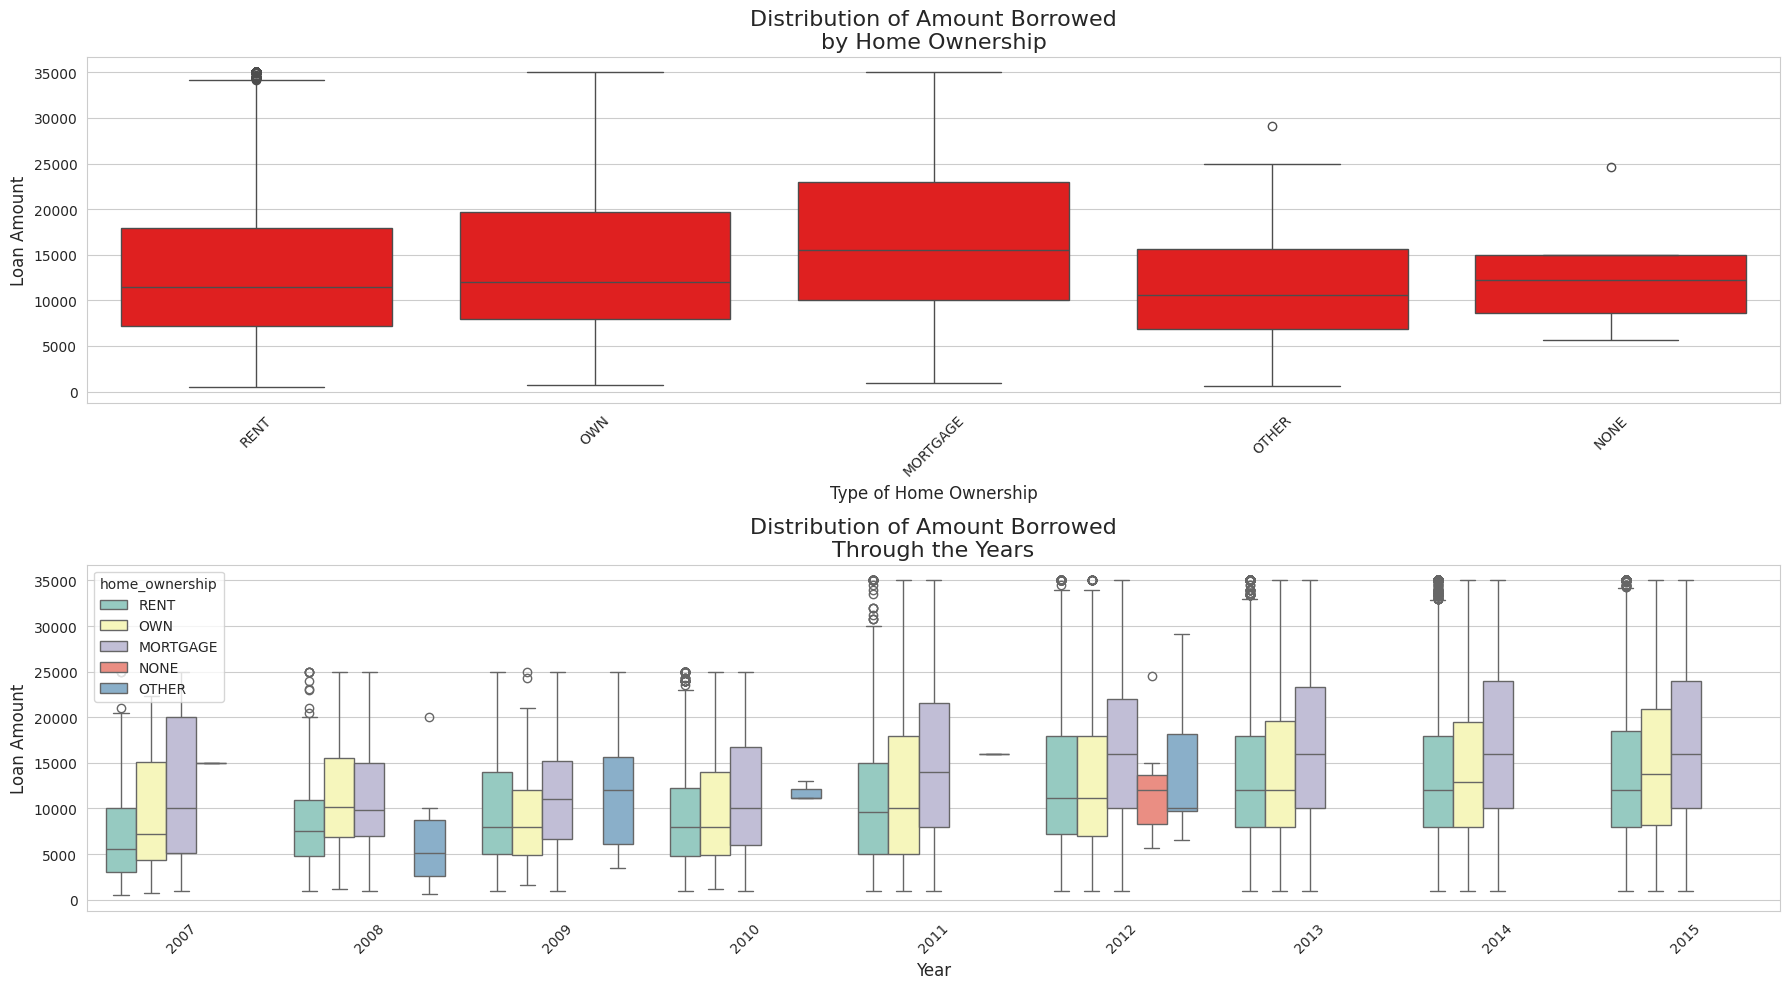

In [36]:
plt.figure(figsize=(18,10))
bad_df = df[df['loan_condition'] == 'Bad Loan']

# ── First subplot: boxplots of loan_amount by home_ownership, all in red ──
ax1 = plt.subplot(2, 1, 1)
sns.boxplot(
    x='home_ownership',
    y='loan_amount',
    hue='loan_condition',
    data=bad_df,
    palette={'Bad Loan': 'r'},
    ax=ax1
)
ax1.tick_params(axis='x', rotation=45)   # rotate labels safely
ax1.set_xlabel("Type of Home Ownership", fontsize=12)
ax1.set_ylabel("Loan Amount", fontsize=12)
ax1.set_title("Distribution of Amount Borrowed\nby Home Ownership", fontsize=16)
ax1.legend_.remove()

# ── Second subplot: boxplots of loan_amount by year, faceted by home_ownership ──
ax2 = plt.subplot(2, 1, 2)
sns.boxplot(
    x='year',
    y='loan_amount',
    hue='home_ownership',
    data=bad_df,
    palette="Set3",
    ax=ax2
)
ax2.tick_params(axis='x', rotation=45)
ax2.set_xlabel("Year", fontsize=12)
ax2.set_ylabel("Loan Amount", fontsize=12)
ax2.set_title("Distribution of Amount Borrowed\nThrough the Years", fontsize=16)

plt.tight_layout()
plt.show()

# **Defaulted Loans and Level of Risk:**

From all the bad loans the one we are most interested about are the loans that are defaulted. Therefore, in this section we will implement an in-depth analysis of these types of Loans and see if we can gain any insight as to which features have a high correlation with the loan being defaulted.

## **Main Aim:**

Determine patters that will allow us to understand somehow factors that contribute to a loan being defaulted

## **Summary:**


*   In the last year recorded, the Midwest and SouthEast regions had the most defaults.
*   Loans that have a high interest rate(above 13.23%) are more likely to become a bad loan.
*   Loans that have a longer maturity date (60 months) are more likely to be a bad loan.


In [37]:
# Get the loan amount for loans that were defaulted by each region.
northe_defaults = df['loan_amount'].loc[(df['region'] == 'NorthEast') & (df['loan_status'] == 'Default')].values.tolist()
southw_defaults = df['loan_amount'].loc[(df['region'] == 'SouthWest') & (df['loan_status'] == 'Default')].values.tolist()
southe_defaults = df['loan_amount'].loc[(df['region'] == 'SouthEast') & (df['loan_status'] == 'Default')].values.tolist()
west_defaults = df['loan_amount'].loc[(df['region'] == 'West') & (df['loan_status'] == 'Default')].values.tolist()
midw_defaults = df['loan_amount'].loc[(df['region'] == 'MidWest') & (df['loan_status'] == 'Default')].values.tolist()

# Cumulative Values
y0_stck=northe_defaults
y1_stck=[y0+y1 for y0, y1 in zip(northe_defaults, southw_defaults)]
y2_stck=[y0+y1+y2 for y0, y1, y2 in zip(northe_defaults, southw_defaults, southe_defaults)]
y3_stck=[y0+y1+y2+y3 for y0, y1, y2, y3 in zip(northe_defaults, southw_defaults, southe_defaults, west_defaults)]
y4_stck=[y0+y1+y2+y3+y4 for y0, y1, y2, y3, y4 in zip(northe_defaults, southw_defaults, southe_defaults, west_defaults, midw_defaults)]

# Make original values strings and add % for hover text
y0_txt=['$' + str(y0) for y0 in northe_defaults]
y1_txt=['$' + str(y1) for y1 in southw_defaults]
y2_txt=['$' + str(y2) for y2 in southe_defaults]
y3_txt=['$' + str(y3) for y3 in west_defaults]
y4_txt=['$'+ str(y4) for y4 in midw_defaults]

year = sorted(df["year"].unique().tolist())

NorthEast_defaults = go.Scatter(
    x= year,
    y= y0_stck,
    text=y0_txt,
    hoverinfo='x+text',
    name='NorthEast',
    mode= 'lines',
    line=dict(width=0.5,
             color='rgb(131, 90, 241)'),
    fill='tonexty'
)
SouthWest_defaults = go.Scatter(
    x=year,
    y=y1_stck,
    text=y1_txt,
    hoverinfo='x+text',
    name='SouthWest',
    mode= 'lines',
    line=dict(width=0.5,
             color='rgb(255, 140, 0)'),
    fill='tonexty'
)

SouthEast_defaults = go.Scatter(
    x= year,
    y= y2_stck,
    text=y2_txt,
    hoverinfo='x+text',
    name='SouthEast',
    mode= 'lines',
    line=dict(width=0.5,
             color='rgb(240, 128, 128)'),
    fill='tonexty'
)

West_defaults = go.Scatter(
    x= year,
    y= y3_stck,
    text=y3_txt,
    hoverinfo='x+text',
    name='West',
    mode= 'lines',
    line=dict(width=0.5,
             color='rgb(135, 206, 235)'),
    fill='tonexty'
)

MidWest_defaults = go.Scatter(
    x= year,
    y= y4_stck,
    text=y4_txt,
    hoverinfo='x+text',
    name='MidWest',
    mode= 'lines',
    line=dict(width=0.5,
             color='rgb(240, 230, 140)'),
    fill='tonexty'
    )


data = [NorthEast_defaults, SouthWest_defaults, SouthEast_defaults, West_defaults, MidWest_defaults]

layout = dict(title = 'Amount Defaulted by Region',
              xaxis = dict(title = 'Year'),
              yaxis = dict(title = 'Amount Defaulted')
             )

fig = dict(data=data, layout=layout)

iplot(fig, filename='basic-area-no-bound')

In [38]:
# create the column up front as empty strings → object dtype
df['interest_payments'] = ''

# now assign without any dtype mismatch
df.loc[df['interest_rate'] <= 13.23, 'interest_payments'] = 'Low'
df.loc[df['interest_rate'] >  13.23, 'interest_payments'] = 'High'

# define your break at the descriptive mean ~13.26
bins  = [-np.inf,  13.23, np.inf]
labels = ['Low', 'High']

df['interest_payments'] = pd.cut(
    df['interest_rate'],
    bins=bins,
    labels=labels
).astype(str)

df.head()

,loan_amount,funded_amount,investor_funds,term,interest_rate,installment,grade,sub_grade,emp_length,home_ownership,...,inq_last_12m,issue_d_clean,year,loan_condition,region,issue_period,emp_length_int,income_category,loan_condition_int,interest_payments
0,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,...,NaN,Dec-2011,2011,Good Loan,SouthWest,2011-12,10.0,Low,0,Low
1,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,...,NaN,Dec-2011,2011,Bad Loan,SouthEast,2011-12,0.5,Low,1,High
2,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,...,NaN,Dec-2011,2011,Good Loan,MidWest,2011-12,10.0,Low,0,High
3,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,...,NaN,Dec-2011,2011,Good Loan,West,2011-12,10.0,Low,0,High
4,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,1 year,RENT,...,NaN,Dec-2011,2011,Good Loan,West,2011-12,1.0,Low,0,Low


In [39]:
df['term'].value_counts()

,count
term,
36 months,621125
60 months,266254


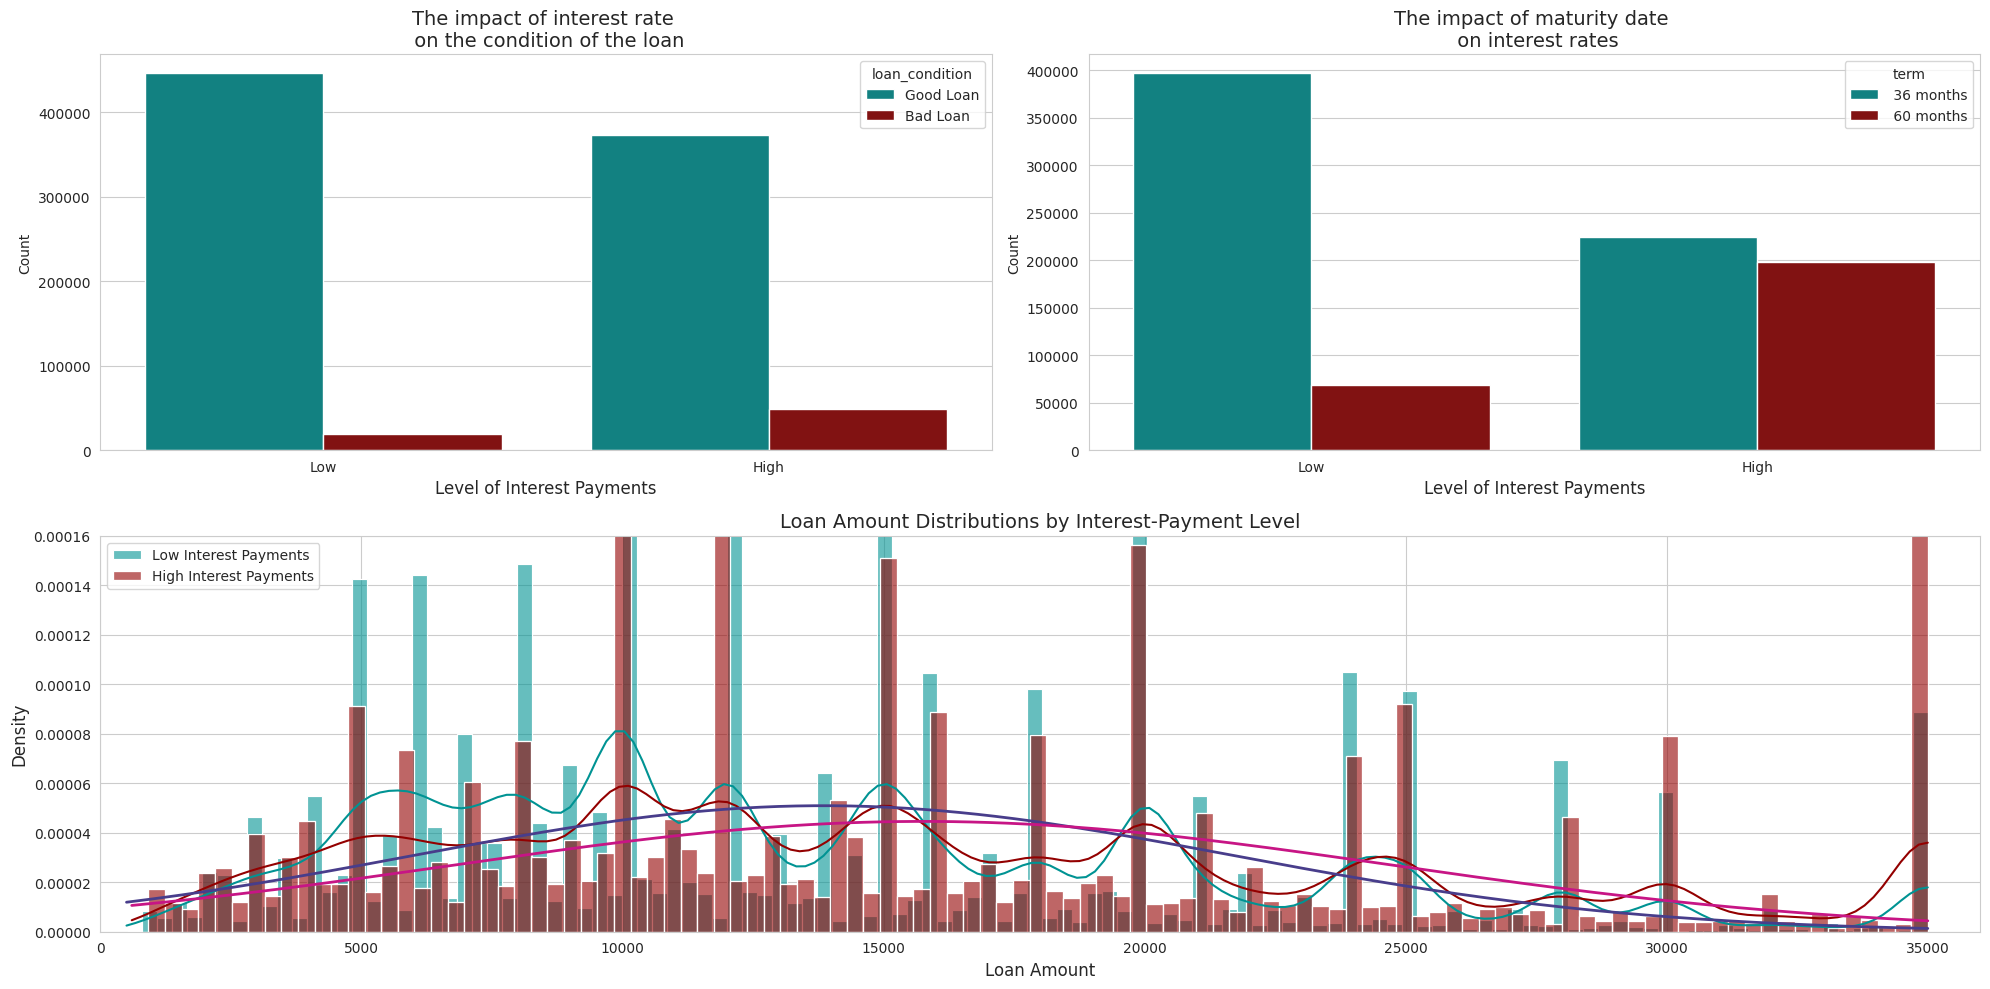

In [40]:
from scipy.stats import norm

plt.figure(figsize=(20,10))

palette = ['#009393', '#930000']
bad = df[df['loan_condition']=='Bad Loan']

# ── Subplot 1: interest_payments vs loan_condition ──
plt.subplot(221)
ax = sns.countplot(
    x='interest_payments',
    data=df,
    palette=palette,
    hue='loan_condition'
)
ax.set_title('The impact of interest rate \n on the condition of the loan', fontsize=14)
ax.set_xlabel('Level of Interest Payments', fontsize=12)
ax.set_ylabel('Count')

# ── Subplot 2: interest_payments vs term ──
plt.subplot(222)
ax1 = sns.countplot(
    x='interest_payments',
    data=df,
    palette=palette,
    hue='term'
)
ax1.set_title('The impact of maturity date \n on interest rates', fontsize=14)
ax1.set_xlabel('Level of Interest Payments', fontsize=12)
ax1.set_ylabel('Count')

# ── Subplot 3: distributions with KDE + normal fit ──
plt.subplot(212)
low  = df.loc[df['interest_payments']=='Low',  'loan_amount']
high = df.loc[df['interest_payments']=='High', 'loan_amount']

# Plot histograms with KDE
ax2 = sns.histplot(
    low,
    stat='density',
    kde=True,
    color='#009393',
    label='Low Interest Payments',
    alpha=0.6
)
ax3 = sns.histplot(
    high,
    stat='density',
    kde=True,
    color='#930000',
    label='High Interest Payments',
    alpha=0.6
)

# Compute and overlay normal fits
for data, color, linecolor in [
    (low,  '#009393', '#483d8b'),
    (high, '#930000', '#c71585'),
]:
    mu, sigma = norm.fit(data)
    xmin, xmax = data.min(), data.max()
    x = np.linspace(xmin, xmax, 200)
    plt.plot(x, norm.pdf(x, mu, sigma),
             color=linecolor, lw=2)

plt.axis([0, 36000, 0, 0.00016])
plt.legend()
plt.title("Loan Amount Distributions by Interest-Payment Level", fontsize=14)
plt.xlabel("Loan Amount", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.tight_layout()
plt.show()


# **Risk Assesment:**

The main aim in this section is to compare the average interest rate for the loan status belonging to each type of loans (Good loan or bad loan) and see if there is any significant difference in the average of interest rate for each of the groups.

## **Summary:**


*   Bad Loans: Most of the loan statuses belonging to this group pay a interest ranging from 15% - 16%.
*   Good Loans: Most of the loan statuses belonging to this group pay interest ranging from 12% - 13%.
*   There has to be a better assesment of risk since there is not that much of a difference in interest payments from Good Loans and Bad Loans.
*   Remember, most loan statuses are Current so there is a risk that at the end of maturity some of these loans might become bad loans.


In [41]:
# Interest rate good loans
avg_fully_paid = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Fully Paid'].values), 2)
avg_current = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Current'].values), 2)
avg_issued = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Issued'].values), 2)
avg_long_fully_paid = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid'].values), 2)



# Interest rate bad loans

avg_default_rates = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Default'].values), 2)
avg_charged_off = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Charged Off'].values), 2)
avg_long_charged_off = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off'].values), 2)
avg_grace_period = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'In Grace Period'].values), 2)
avg_short_late = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Late (16-30 days)'].values), 2)
avg_long_late = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Late (31-120 days)'].values), 2)


# Take to a dataframe

data = [
    go.Scatterpolar(
        mode='lines+markers',
      r = [avg_fully_paid, avg_current, avg_issued, avg_long_fully_paid],
      theta = ['Fully Paid', 'Current', 'Issued', 'No C.P. Fully Paid'],
      fill = 'toself',
      name = 'Good Loans',
        line = dict(
        color = "#63AF63"
      ),
      marker = dict(
        color = "#B3FFB3",
        symbol = "square",
        size = 8
      ),
      subplot = "polar",
    ),
    go.Scatterpolar(
        mode='lines+markers',
      r = [avg_default_rates, avg_charged_off, avg_long_charged_off, avg_grace_period, avg_short_late, avg_long_late],
      theta = ['Default Rate', 'Charged Off', 'C.P. Charged Off', 'In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)'],
      fill = 'toself',
      name = 'Bad Loans',
        line = dict(
        color = "#C31414"
      ),
      marker = dict(
        color = "#FF5050",
        symbol = "square",
        size = 8
      ),
      subplot = "polar2"
    )
]

layout = go.Layout(
    title="Average Interest Rates <br> Loan Status Distribution",
    showlegend = False,
     paper_bgcolor = "rgb(255, 248, 243)",
    polar = dict(
      domain = dict(
        x = [0,0.4],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 8
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 8
        ),
        rotation = 90,
        direction = "counterclockwise"
      )
    ),
    polar2 = dict(
      domain = dict(
        x = [0.6,1],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 8
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 8
        ),
        rotation = 90,
        direction = "clockwise"
      ),
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='polar/directions')

# **Condition of Loans and Purpose:**

In this section we will go into depth regarding the reasons for clients to apply for a loan. Our main aim is to see if there are purposes that contribute to a "higher" risk whether the loan will be repaid or not.

## **Summary:**


*   Bad Loans Count: People that apply for educational and small business purposed tend to have a higher risk of being a bad loan. (% wise)
*   Most frequent Purpose: The reason that clients applied the most for a loan was to consolidate debt.
*   Less frequent purpose: Clients applied less for educational purposes for all three income categories.
*   Interest Rates: In all reasons for application except (medical, small business and credi card), the low income category has a higher interest rate. Something that could possibly explain this is the amount of capital that is needed from other income categories that might explain why the low income categories interest rate for these puposes are lower.
*   Bad/Good Ratio: Except for educational purposes (we see a spike in high income this is due to the reasons that only two loans were issued and one was a bad loan which caused this ratio to spike to 50%.), but we can see that in all other purposed the bad good ratio is lower the higher your income category.

In [42]:
df['purpose'].value_counts()

# Education, renewable energy, wedding are the purposed that contains highest bad loans percent wise.

purpose_condition = round(pd.crosstab(df['loan_condition'], df['purpose']).apply(lambda x: x/x.sum() * 100), 2)

purpose_bad_loans = purpose_condition.values[0].tolist()
purpose_good_loans = purpose_condition.values[1].tolist()
purpose = purpose_condition.columns


bad_plot = go.Bar(
    x=purpose,
    y=purpose_bad_loans,
    name = 'Bad Loans',
    text='%',
    marker=dict(
        color='rgba(219, 64, 82, 0.7)',
        line = dict(
            color='rgba(219, 64, 82, 1.0)',
            width=2
        )
    )
)

good_plot = go.Bar(
    x=purpose,
    y=purpose_good_loans,
    name='Good Loans',
    text='%',
    marker=dict(
        color='rgba(50, 171, 96, 0.7)',
        line = dict(
            color='rgba(50, 171, 96, 1.0)',
            width=2
        )
    )
)


data = [bad_plot, good_plot]

layout = go.Layout(
    title='Condition of Loan by Purpose',
    xaxis=dict(
        title=''
    ),
    yaxis=dict(
        title='% of the Loan',
    ),
    paper_bgcolor='#FFF8DC',
    plot_bgcolor='#FFF8DC',
    showlegend=True
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='condition_purposes')

In [43]:
# Average interest by income category and purposes
# Which purpose carries a higher interest rate and does income category have an influence on risk?
# Is LendingClub deploying loan amount where there is a high risk (interest_rate)
# Remember we learned that interest_rates is a key metric in evaluating risk.



group_income_purpose = (
    df
    .groupby(
        ['income_category','purpose'],
        as_index=False,
        observed=False      # explicit current behavior
    )['interest_rate']
    .mean()
)

group_dti_purpose = (
    df
    .groupby(
        ['income_category','purpose'],
        as_index=False,
        observed=False
    )['loan_amount']
    .mean()
)

loan_a = group_dti_purpose['loan_amount'].values



# High Car 10.32 15669
new_groupby = group_income_purpose.assign(total_loan_amount=loan_a)
sort_group_income_purpose = new_groupby.sort_values(by="income_category", ascending=True)

In [44]:
loan_count = df.groupby(['income_category', 'purpose'])['loan_condition'].apply(lambda x: x.value_counts())
d={"loan_c": loan_count}
loan_c_df = pd.DataFrame(data=d).reset_index()
loan_c_df = loan_c_df.rename(columns={"level_2": "loan_condition"})


# Good loans & Bad Loans
good_loans = loan_c_df.loc[loan_c_df['loan_condition'] == "Good Loan"].sort_values(by="income_category", ascending=True)
bad_loans = loan_c_df.loc[loan_c_df['loan_condition'] == "Bad Loan"].sort_values(by="income_category", ascending=True)
sort_group_income_purpose['good_loans_count'] = good_loans['loan_c'].values
sort_group_income_purpose['bad_loans_count'] = bad_loans['loan_c'].values
sort_group_income_purpose['total_loans_issued'] = (good_loans['loan_c'].values + bad_loans['loan_c'].values)
sort_group_income_purpose['bad/good ratio (%)'] = np.around(bad_loans['loan_c'].values / (bad_loans['loan_c'].values + good_loans['loan_c'].values), 4) * 100
final_df = sort_group_income_purpose.sort_values(by='income_category', ascending=True)
final_df.style.background_gradient('coolwarm')

<ipython-input-44-a9e3c04e7f3a>:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,income_category,purpose,interest_rate,total_loan_amount,good_loans_count,bad_loans_count,total_loans_issued,bad/good ratio (%)
0,Low,car,12.183347,8296.477955,7126,540,7666,7.040000
6,Low,major_purchase,12.858240,10236.059941,12785,1112,13897,8.000000
1,Low,credit_card,11.970933,13822.853040,158338,10354,168692,6.140000
2,Low,debt_consolidation,13.756933,14075.203764,398907,36523,435430,8.390000
4,Low,home_improvement,13.242259,12437.364771,35176,2815,37991,7.410000
5,Low,house,16.122573,12936.505339,2542,361,2903,12.440000
10,Low,renewable_energy,15.428473,8744.979079,413,65,478,13.600000
3,Low,educational,12.169160,6037.270341,301,80,381,21.000000
8,Low,moving,15.802668,6884.091403,4053,553,4606,12.010000
9,Low,other,15.130934,8861.874881,32933,3720,36653,10.150000


In [45]:
final_df = final_df.sort_values(by="purpose", ascending=False)

In [46]:
# Work on a plot to explain better the correlations between the different columns in final_df dataframe.
# We will do a Subplot in Plotly with

pio.renderers.default = 'colab'

purpose_labels = final_df['purpose'].unique().tolist()
high_income   = final_df.loc[final_df['income_category']=='High','interest_rate'].tolist()
medium_income = final_df.loc[final_df['income_category']=='Medium','interest_rate'].tolist()
low_income    = final_df.loc[final_df['income_category']=='Low','interest_rate'].tolist()

trace1 = go.Scatter(x=high_income,   y=purpose_labels, mode='markers',
                    name='High Income',   marker=dict(color='#0040FF', size=12))
trace2 = go.Scatter(x=medium_income, y=purpose_labels, mode='markers',
                    name='Medium Income', marker=dict(color='#FE9A2E', size=12))
trace3 = go.Scatter(x=low_income,    y=purpose_labels, mode='markers',
                    name='Low Income',    marker=dict(color='#FE2E2E', size=12))

fig = go.Figure(data=[trace1, trace2, trace3])
fig.update_layout(
    title="Average Purpose Interest Rate<br><i>by Income Category</i>",
    xaxis_title="Average Interest Rate",
    yaxis_title="Purpose",
    xaxis=dict(type='linear')   # ensure numeric axis
)
fig.show()


In [47]:
from plotly.subplots import make_subplots

# make it render in Colab
pio.renderers.default = "colab"

# your labels
purpose_labels = final_df['purpose'].unique()

# Good‐loan counts
good_high_cnt = final_df.loc[final_df['income_category']=="High",   'good_loans_count'].tolist()
good_med_cnt  = final_df.loc[final_df['income_category']=="Medium", 'good_loans_count'].tolist()
good_low_cnt  = final_df.loc[final_df['income_category']=="Low",    'good_loans_count'].tolist()

# Bad‐loan counts
bad_high_cnt = final_df.loc[final_df['income_category']=="High",   'bad_loans_count'].tolist()
bad_med_cnt  = final_df.loc[final_df['income_category']=="Medium", 'bad_loans_count'].tolist()
bad_low_cnt  = final_df.loc[final_df['income_category']=="Low",    'bad_loans_count'].tolist()

# build bar traces
good_traces = [
    go.Bar(x=good_high_cnt, y=purpose_labels, name='High Income',   orientation='h', marker_color='#0040FF', legendgroup='good'),
    go.Bar(x=good_med_cnt,  y=purpose_labels, name='Medium Income', orientation='h', marker_color='#FE9A2E', legendgroup='good'),
    go.Bar(x=good_low_cnt,  y=purpose_labels, name='Low Income',    orientation='h', marker_color='#FE2E2E', legendgroup='good'),
]

bad_traces = [
    go.Bar(x=bad_high_cnt, y=purpose_labels, showlegend=False, name='High Income',   orientation='h', marker_color='#0040FF', legendgroup='bad'),
    go.Bar(x=bad_med_cnt,  y=purpose_labels, showlegend=False, name='Medium Income', orientation='h', marker_color='#FE9A2E', legendgroup='bad'),
    go.Bar(x=bad_low_cnt,  y=purpose_labels, showlegend=False, name='Low Income',    orientation='h', marker_color='#FE2E2E', legendgroup='bad'),
]

# make 2×1 subplots
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=False,
    vertical_spacing=0.15,
    subplot_titles=("Good Loans Issued", "Bad Loans Issued")
)

# add traces
for t in good_traces:
    fig.add_trace(t, row=1, col=1)
for t in bad_traces:
    fig.add_trace(t, row=2, col=1)

# layout tweaks
fig.update_layout(
    height=800,
    width=900,
    title_text="Issuance of Loans by Purpose and Income Category",
    barmode='stack',
    xaxis1=dict(title="Number of Loans Issued"),
    xaxis2=dict(title="Number of Loans Issued")
)

fig.show()


In [48]:
# Next task a Radar Chart with the bad/good ratio to see if it justifies the amount of loans issued towards housing
high_ratio = final_df.loc[final_df['income_category'] == 'High']
medium_ratio = final_df.loc[final_df['income_category'] == 'Medium']
low_ratio = final_df.loc[final_df['income_category'] == 'Low']

data = [
    go.Scatterpolar(
        mode='lines+markers',
      r = high_ratio['bad/good ratio (%)'].values.tolist(),
      theta = high_ratio['purpose'].unique(),
      fill = 'toself',
      name = 'High Income',
        line = dict(
        color = "#63AF63"
      ),
      marker = dict(
        color = "#B3FFB3",
        symbol = "square",
        size = 8
      ),
      subplot = "polar",
    ),
    go.Scatterpolar(
        mode='lines+markers',
      r = medium_ratio['bad/good ratio (%)'].values.tolist(),
      theta = medium_ratio['purpose'].unique(),
      fill = 'toself',
      name = 'Medium Income',
        line = dict(
        color = "#C31414"
      ),
      marker = dict(
        color = "#FF5050",
        symbol = "square",
        size = 8
      ),
      subplot = "polar2"
    ),
    go.Scatterpolar(
        mode='lines+markers',
      r = low_ratio['bad/good ratio (%)'].values.tolist(),
      theta = low_ratio['purpose'].unique(),
      fill = 'toself',
      name = 'Low Income',
        line = dict(
        color = "#C9FFC7"
      ),
      marker = dict(
        color = "#8CB28B",
        symbol = "square",
        size = 8
      ),
      subplot = "polar3"
    ),
]

layout = go.Layout(
    title="Bad/Good Ratio <br> (By Purpose)",
    showlegend = False,
     paper_bgcolor = "rgb(255, 206, 153)",
    polar = dict(
      domain = dict(
        x = [0,0.3],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 6
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 6
        ),
        rotation = 90,
        direction = "counterclockwise"
      )
    ),
    polar2 = dict(
      domain = dict(
        x = [0.35,0.65],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 6
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 6
        ),
        rotation = 85,
        direction = "clockwise"
      ),
    ),
    polar3 = dict(
      domain = dict(
        x = [0.7, 1],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 6
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 6
        ),
        rotation = 90,
        direction = "clockwise"
      ),
    ))

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename = "radar/multiple")

# **Feature Engineering and Neural Network:**

## Steps:

*   There are features that are redundant (as show in the beginning of this kernel in the distribution subplots) having no effect towards the "loan_condition" label so we need to drop these features.
*   Use StrattifiedShuffleSplit to have approximately the same ratio of bad loans compared to good loans in both training and testing data. Remember that over 92% of the loans are considered good loans so it is important to have this same ration across training and testing sets.
*   Scale numeric features and encode categorical features from our dataframe.
*   Run our Neural Network containing the number of inputs, 2 hidden layers (first: 15 nodes, second: 5 nodes) and the number of outputs which is equivalent to 2.

In [49]:
# Copy Dataframe
complete_df = df.copy()


# Handling Missing Numeric Values

# Transform Missing Values for numeric dataframe
# Nevertheless check what these variables mean tomorrow in the morning.
for col in ('dti_joint', 'annual_inc_joint', 'il_util', 'mths_since_rcnt_il', 'open_acc_6m', 'open_il_6m', 'open_il_12m',
           'open_il_24m', 'inq_last_12m', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl',
           'mths_since_last_record', 'mths_since_last_major_derog', 'mths_since_last_delinq', 'total_bal_il', 'tot_coll_amt',
           'tot_cur_bal', 'total_rev_hi_lim', 'revol_util', 'collections_12_mths_ex_med', 'open_acc', 'inq_last_6mths',
           'verification_status_joint', 'acc_now_delinq'):
    complete_df[col] = complete_df[col].fillna(0)



# # Get the mode of next payment date and last payment date and the last date credit amount was pulled
complete_df["next_pymnt_d"] = complete_df.groupby("region")["next_pymnt_d"].transform(lambda x: x.fillna(x.mode))
complete_df["last_pymnt_d"] = complete_df.groupby("region")["last_pymnt_d"].transform(lambda x: x.fillna(x.mode))
complete_df["last_credit_pull_d"] = complete_df.groupby("region")["last_credit_pull_d"].transform(lambda x: x.fillna(x.mode))
complete_df["earliest_cr_line"] = complete_df.groupby("region")["earliest_cr_line"].transform(lambda x: x.fillna(x.mode))

# # Get the mode on the number of accounts in which the client is delinquent
complete_df["pub_rec"] = complete_df.groupby("region")["pub_rec"].transform(lambda x: x.fillna(x.median()))

# # Get the mean of the annual income depending in the region the client is located.
complete_df["annual_income"] = complete_df.groupby("region")["annual_income"].transform(lambda x: x.fillna(x.mean()))

# Get the mode of the  total number of credit lines the borrower has
complete_df["total_acc"] = complete_df.groupby("region")["total_acc"].transform(lambda x: x.fillna(x.median()))

# Mode of credit delinquencies in the past two years.
complete_df["delinq_2yrs"] = complete_df.groupby("region")["delinq_2yrs"].transform(lambda x: x.fillna(x.mean()))

In [50]:
# Drop these variables before scaling but don't drop these when we perform feature engineering on missing values.
# Columns to delete or fix: earliest_cr_line, last_pymnt_d, next_pymnt_d, last_credit_pull_d, verification_status_joint

# ---->>>> Fix the problems shown during scaling with the columns above.

cols_to_drop = [
    'issue_d', 'income_category', 'region', 'year', 'emp_length',
    'loan_condition','earliest_cr_line','last_pymnt_d','next_pymnt_d',
    'last_credit_pull_d','verification_status_joint','emp_length_int',
    'total_rec_prncp','funded_amount','investor_funds','sub_grade',
    'complete_date','loan_status','interest_payments','initial_list_status',
    'out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv',
    'total_rec_int','total_rec_late_fee','recoveries',
    'collection_recovery_fee','last_pymnt_amnt','collections_12_mths_ex_med',
    'mths_since_last_major_derog','policy_code','application_type',
    'annual_inc_joint','dti_joint','acc_now_delinq','tot_coll_amt',
    'tot_cur_bal','open_acc_6m','open_il_6m','open_il_12m','open_il_24m',
    'mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m',
    'open_rv_24m','max_bal_bc','all_util','total_rev_hi_lim',
    'inq_fi','total_cu_tl','inq_last_12m'
]

complete_df.drop(cols_to_drop, axis=1, inplace=True, errors='ignore')

In [51]:
complete_df.columns

Index(['loan_amount', 'term', 'interest_rate', 'installment', 'grade',
       'home_ownership', 'annual_income', 'verification_status', 'pymnt_plan',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'issue_d_clean',
       'issue_period', 'loan_condition_int'],
      dtype='object')

In [52]:
complete_df.isnull().sum().max() # Maximum number of nulls.

0

In [53]:
# Let's make a copy of the dataframe to avoid confusion.
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression


len(complete_df['loan_condition_int'])
# Loan Ratios (Imbalanced classes)
complete_df['loan_condition_int'].value_counts()/len(complete_df['loan_condition_int']) * 100

,count
loan_condition_int,
0,92.40133
1,7.59867


The purpose of the code below is to have the same ratio across our training and test sets.

In [54]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_set, test_set in stratified.split(complete_df, complete_df["loan_condition_int"]):
    stratified_train = complete_df.loc[train_set]
    stratified_test = complete_df.loc[test_set]

print('Train set ratio \n', stratified_train["loan_condition_int"].value_counts()/len(df))
print('Test set ratio \n', stratified_test["loan_condition_int"].value_counts()/len(df))

Train set ratio 
 loan_condition_int
0    0.739211
1    0.060789
Name: count, dtype: float64
Test set ratio 
 loan_condition_int
0    0.184803
1    0.015198
Name: count, dtype: float64


In [55]:
train_df = stratified_train
test_df = stratified_test


# Let's Shuffle the data
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)


# Train set (Normal training dataset)
X_train = train_df.drop('loan_condition_int', axis=1)
y_train = train_df['loan_condition_int']


# Test Dataset
X_test = test_df.drop('loan_condition_int', axis=1)
y_test = test_df['loan_condition_int']

In [56]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [57]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [58]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose      import ColumnTransformer

# pick out just true numeric dtypes
numeric_cols     = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", StandardScaler(),                 numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore",
                          sparse_output=False),
           categorical_cols),
])

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed  = preprocessor.transform(X_test)


In [59]:
# Convert the PeriodIndex into a POSIX timestamp (nanoseconds since epoch)
X_train['year_month_ord'] = (
    X_train['issue_period']        # your PeriodDtype column
       .dt
       .to_timestamp()             # → datetime64[ns]
       .astype('int64')            # → integer nanoseconds
)
X_test['year_month_ord'] = (
    X_test['issue_period']
       .dt
       .to_timestamp()
       .astype('int64')
)

# Now re-select true numeric columns (you’ll see year_month_ord in here)
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numerics:", numeric_cols)
print("Categoricals:", categorical_cols)

Numerics: ['loan_amount', 'interest_rate', 'installment', 'annual_income', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'year_month_ord']
Categoricals: ['term', 'grade', 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'issue_d_clean', 'issue_period']


In [60]:
from sklearn.compose      import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 1) Make sure your train/test have no Period dtypes
#    (either drop issue_period or convert it to an int timestamp or ordinal first)

# 2) Recompute the column lists
numeric_cols     = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

# 3) Build the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ],
    remainder="drop"   # any other columns are dropped
)

# 4) Fit/transform in one go
X_train = preprocessor.fit_transform(X_train)
X_test  = preprocessor.transform(X_test)

In [61]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
# log_reg_sm = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [62]:
from sklearn.metrics import accuracy_score

normal_ypred = log_reg.predict(X_test)
print(accuracy_score(y_test, normal_ypred))

0.9239840879893619


In [63]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 1) Cast to smaller dtypes
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
y_train = y_train.astype('int32')
y_test  = y_test.astype('int32')

# 2) Build tf.data pipelines
batch_size = 32  # try lowering if you still OOM
train_ds = (
    tf.data.Dataset
      .from_tensor_slices((X_train, y_train))
      .shuffle(buffer_size=10_000, seed=42, reshuffle_each_iteration=True)
      .batch(batch_size)
      .prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    tf.data.Dataset
      .from_tensor_slices((X_test, y_test))
      .batch(batch_size)
      .prefetch(tf.data.AUTOTUNE)
)

# 3) Define your model with tf.keras
tf.keras.utils.set_random_seed(42)

n_inputs  = X_train.shape[1]
model = keras.Sequential([
    layers.Input(shape=(n_inputs,), name="input"),
    layers.Dense(66, activation="relu", name="hidden1"),
    layers.Dense(66, activation="relu", name="hidden2"),
    layers.Dense(2, name="outputs")   # logits for 2 classes
], name="loan_risk_dnn")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

# 4) Train on the Dataset
history = model.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds
)



Epoch 1/20
22185/22185 ━━━━━━━━━━━━━━━━━━━━ 88s 4ms/step - accuracy: 0.9235 - loss: 0.2417 - val_accuracy: 0.9240 - val_loss: 0.2360
Epoch 2/20
22185/22185 ━━━━━━━━━━━━━━━━━━━━ 74s 3ms/step - accuracy: 0.9238 - loss: 0.2394 - val_accuracy: 0.9240 - val_loss: 0.2363
Epoch 3/20
22185/22185 ━━━━━━━━━━━━━━━━━━━━ 73s 3ms/step - accuracy: 0.9240 - loss: 0.2479 - val_accuracy: 0.9240 - val_loss: 0.2379
Epoch 4/20
22185/22185 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - accuracy: 0.9239 - loss: 0.2376 - val_accuracy: 0.9212 - val_loss: 0.2401
Epoch 5/20
22185/22185 ━━━━━━━━━━━━━━━━━━━━ 72s 3ms/step - accuracy: 0.9239 - loss: 0.2380 - val_accuracy: 0.9240 - val_loss: 0.2356
Epoch 6/20
22185/22185 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - accuracy: 0.9239 - loss: 0.2384 - val_accuracy: 0.9240 - val_loss: 0.2401
Epoch 7/20
22185/22185 ━━━━━━━━━━━━━━━━━━━━ 73s 3ms/step - accuracy: 0.9240 - loss: 0.2399 - val_accuracy: 0.9240 - val_loss: 0.2365
Epoch 8/20
22185/22185 ━━━━━━━━━━━━━━━━━━━━ 100s 4ms/step - accuracy:

Architecture of the Neural Network

In [ ]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add()
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))